In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ['PRJ'] = "/Users/ymohit/skigp/"

import math
import scipy
import numpy as np

# Viz specific 
import warnings
import matplotlib.cbook
# import seaborn as sns
# sns.set()

import matplotlib.gridspec as gridspec
from pylab import rcParams
from matplotlib import pyplot as plt
from IPython.core.display import  HTML

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Loading modules from fkigp
#### (Re-run below cell in case output is flooded by deprication warnings)

In [6]:

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from fkigp.utils import tic, toc, toc_report, grid2extent 
from fkigp.datautils import get_num_dims
from fkigp.dataloader import DataLoader, DEFAULT_NUMPY_DTYPE
from fkigp.gridutils import grid_coords, grid_points

from fkigp.kissgp import KissGpExp
from fkigp.configs import DatasetType, Structdict, Frameworks, GsGPType

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Test-1 (one-dimensional synthetic data): Fitting the sine wave 
#### Expected outcomes: a) RMSE < 0.2 and b) mean inference forms sine passing through observed data.



Running and reporting  KISS-GP ...


#### Model description:
Grid sizes: [50]
Num dims: 1
Grid bounds: ((-1.0, 1.0),)
####

RMSE:  0.017092766095109166
Final MAE:  0.011924485838108534


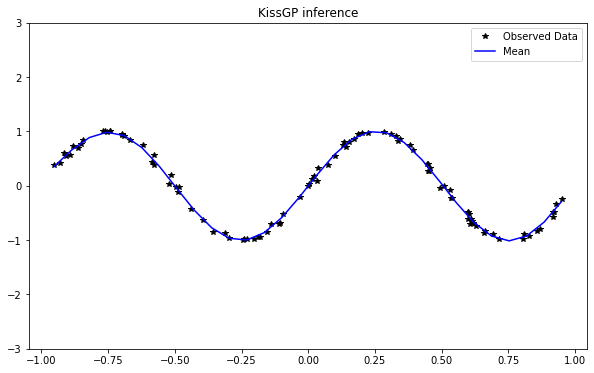

CPU times: user 248 ms, sys: 15 ms, total: 263 ms
Wall time: 270 ms


In [3]:
%%time

##### TEST-1:
##-----------

## Visually confirming the KissGP prediction on the toy sine dataset along with MAE metric. 

config = Structdict()
config['data_type'] = DatasetType.SINE
config['grid_rate'] = 0.5
config['num_dims'] = 1


print("\n\nRunning and reporting  KISS-GP ...\n")
sine_kissgp = KissGpExp(config=config, data_loader=DataLoader(config=config))
sine_kissgp.load_data()
sine_kissgp.build()

hypers = {
    'noise_covar.raw_noise': -5.12708854675293/2,
    'covar_module.base_kernel.raw_outputscale': 1.1689740419387817,
    'covar_module.base_kernel.base_kernel.raw_lengthscale': -1.002593994140625,
}
    
sine_kissgp.model.initialize(**hypers)  
sine_kissgp.report(fill=False, title="KissGP inference")

## Test-2 (one-dimensional real data): Inference on sound data from Wilson et al., ICML, 2015. 
#### Expected outcome: SMAE ~ 0.2

In [4]:
##### TEST-2:
##-----------

## Reproducing results of Figure 3 (c). SMAE is clearly above or equal to 0.2 on Natural sound modelling dataset. 
## Kiss-gp implementation of  in Gpytorch obtains SMAE value ~= 0.197. 

'''
    1. Andrew G Wilson and Hannes Nickisch. Kernel interpolation for scalable structured Gaus-sian  processes  (KISS-GP).   
        InInternational Conferenceon Machine Learning(ICML), pages 1775–1784, 2015.
'''


## Training KISS-GP on natural sound modelling 
config = Structdict()
config['data_type'] = DatasetType.SOUND
config['grid_size'] = 8000
config['num_dims'] = 1
config['num_iterations'] = 100
config['zero_mean'] = True

sound_kissgp = KissGpExp(config=config, data_loader=DataLoader(config=config))
sound_kissgp.load_data()
sound_kissgp.build()

print("\n\nRunning KISS-GP ...\n")
sound_kissgp.init_params()
#sound_kissgp.fit(verbose=False)  --> This step is time consuming. Therefore, we will place previously tuned parameters. 
hypers = {
'noise_covar.raw_noise': -10.966407775878906/2,  
'covar_module.base_kernel.raw_outputscale': -5.950943552288058, 
'covar_module.base_kernel.base_kernel.raw_lengthscale': 10.895852088928223
}
 
sound_kissgp.model.initialize(**hypers)
t1 = tic()
smae = sound_kissgp.compute_smae(tol=1e-2)
t2 = toc(t1)
toc_report(t2, tag="InfGP")

print("SMAE: ", smae)

print("\n\n")


#### Model description:
Grid sizes: [8000]
Num dims: 1
Grid bounds: ((1, 60000),)
####



Running KISS-GP ...

   InfGP: wall=354.80 ms, sys=346.22 ms
SMAE:  0.20026923843467603





## Test-3 (multi-dimensional synthetic data): Inference on synthetic data sampled from RBF kernel 
#### Expected outcome: RMSE ~ 0.6, NumIterations ~ 40, visually similar results for function and samples, absoluete error diff colorbar range (0 to -7)


#### Model description:
Grid sizes: [71, 71]
Num dims: 2
Grid bounds: ((-5, 5), (-5, 5))
####



Running KISS-GP ...

RMSE:  0.6726708970056784





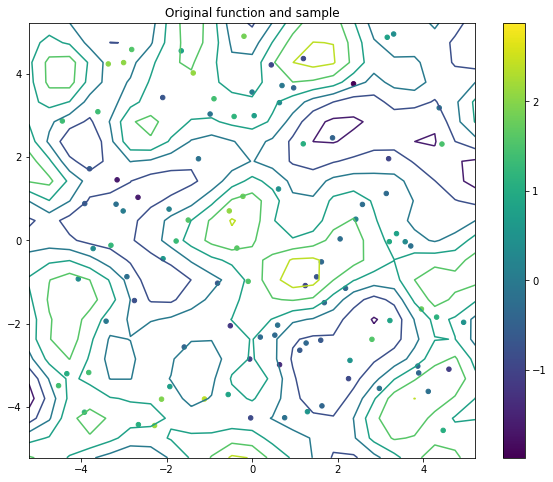

NumIters: 42


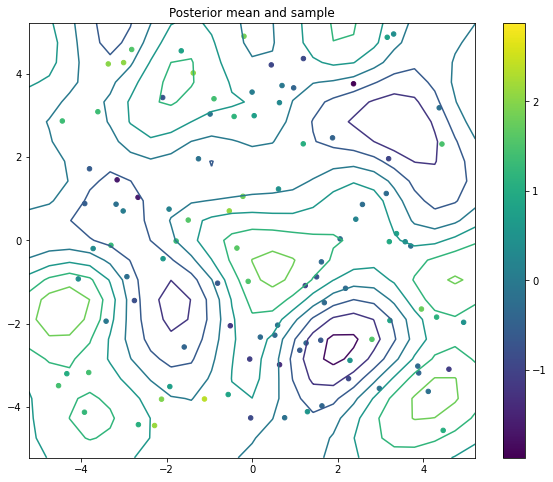

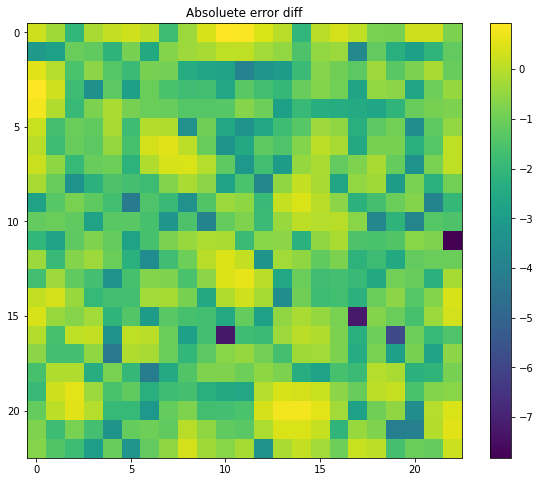

CPU times: user 1.44 s, sys: 124 ms, total: 1.56 s
Wall time: 1.3 s


In [5]:
%%time 
from fkigp.gps.constraints import inv_softplus, DEFAULT_SOFTPLUS_VALUE

##### TEST-3:
##-----------

## Training KISS-GP on synthetic 2-d dimensional dataset 

config = Structdict()
config['data_type'] = DatasetType.SYNGPND
config['grid_size'] = 5000
config['num_dims'] = 2
config['num_iterations'] = 100
config['zero_mean'] = True
config['N'] = 800
config['ntest'] = 5400
config['sigma'] = 0.4
config['grid_bounds'] = tuple([(-5, 5), (-5, 5)]) # default choice in dataloader for DatasetType.SYNGPND

synthetic_kissgp = KissGpExp(config=config, data_loader=DataLoader(config=config))
synthetic_kissgp.load_data()
synthetic_kissgp.build()

print("\n\nRunning KISS-GP ...\n")
synthetic_kissgp.init_params()

hypers = {
    'noise_covar.raw_noise': inv_softplus(config['sigma']), 
    'covar_module.base_kernel.raw_outputscale': DEFAULT_SOFTPLUS_VALUE,
    'covar_module.base_kernel.base_kernel.raw_lengthscale': np.array([inv_softplus(1.0), inv_softplus(1.0)])
}

synthetic_kissgp.model.initialize(**hypers)

rmse = synthetic_kissgp.compute_rmse(tol=1e-3)
print("RMSE: ", rmse)
print("\n\n")

## Visualizing the output
test_grid = synthetic_kissgp.data_loader.test_grid
f_test = synthetic_kissgp.test_y
test_shape = [test_grid[0][2], test_grid[1][2]]

F = f_test.reshape(test_shape)
vmin, vmax = F.min(), F.max()

x = synthetic_kissgp.train_x
y = synthetic_kissgp.train_y
cmap = 'viridis'
plt.figure(figsize=(10,8))
plt.title('Original function and sample')
plt.contour(F, extent=grid2extent(test_grid), vmin=vmin, vmax=vmax, cmap=cmap)
plt.scatter(x[:,1], x[:,0], c=y, s=20, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar()
plt.show()

mu_ours = synthetic_kissgp.predict(synthetic_kissgp.test_x, tol=1e-7, verbose=True)[0]
MU = mu_ours.reshape(test_shape)
plt.figure(figsize=(10,8))
plt.title('Posterior mean and sample')
plt.contour(MU, extent=grid2extent(test_grid), vmin=vmin, vmax=vmax, cmap=cmap)
plt.scatter(x[:,1], x[:,0], c=y, s=20, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar()
plt.show()

plt.figure(figsize=(10,8))
plt.title('Absoluete error diff')
plt.imshow(np.log(np.abs(F - MU)))
plt.colorbar()
plt.show()